# 🛍️ Customer Segmentation in E-Commerce Using Machine Learning

Goal: Segment customers and predict high-value customers based on their purchasing behavior.

### 📚 Data Preparation

- Load and explore customer transaction data

- Feature engineering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('ecommerce_customer_data_large.csv')
df.head(15)

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Payment Method,Customer Age,Returns,Customer Name,Gender
0,44605,2023-05-03 21:30:02,Home,177,1,PayPal,31,1.0,John Rivera,Female
1,44605,2021-05-16 13:57:44,Electronics,174,3,PayPal,31,1.0,John Rivera,Female
2,44605,2020-07-13 06:16:57,Books,413,1,Credit Card,31,1.0,John Rivera,Female
3,44605,2023-01-17 13:14:36,Electronics,396,3,Cash,31,0.0,John Rivera,Female
4,44605,2021-05-01 11:29:27,Books,259,4,PayPal,31,1.0,John Rivera,Female
5,13738,2022-08-25 06:48:33,Home,191,3,Credit Card,27,1.0,Lauren Johnson,Female
6,13738,2023-07-25 05:17:24,Electronics,205,1,Credit Card,27,NaN,Lauren Johnson,Female
7,13738,2023-02-05 19:31:48,Books,370,5,Cash,27,1.0,Lauren Johnson,Female
8,13738,2021-12-21 03:29:05,Home,12,2,Cash,27,NaN,Lauren Johnson,Female
9,13738,2023-02-09 00:53:14,Electronics,40,4,Cash,27,0.0,Lauren Johnson,Female


In [3]:
# Drop duplicates and rows with missing important info
df.drop_duplicates(inplace=True)
df.dropna(subset=['Customer ID', 'Purchase Date', 'Product Price', 'Quantity', 'Customer Age', 'Returns', 'Gender'], inplace=True)

# Convert date and calculate total amount
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])
df['TotalAmount'] = df['Product Price'] * df['Quantity']

# Map Gender: Female -> 1, Male -> 0
df['Gender'] = df['Gender'].map({'Female': 1, 'Male': 0})

df.head(15)

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Payment Method,Customer Age,Returns,Customer Name,Gender,TotalAmount
0,44605,2023-05-03 21:30:02,Home,177,1,PayPal,31,1.0,John Rivera,1,177
1,44605,2021-05-16 13:57:44,Electronics,174,3,PayPal,31,1.0,John Rivera,1,522
2,44605,2020-07-13 06:16:57,Books,413,1,Credit Card,31,1.0,John Rivera,1,413
3,44605,2023-01-17 13:14:36,Electronics,396,3,Cash,31,0.0,John Rivera,1,1188
4,44605,2021-05-01 11:29:27,Books,259,4,PayPal,31,1.0,John Rivera,1,1036
5,13738,2022-08-25 06:48:33,Home,191,3,Credit Card,27,1.0,Lauren Johnson,1,573
7,13738,2023-02-05 19:31:48,Books,370,5,Cash,27,1.0,Lauren Johnson,1,1850
9,13738,2023-02-09 00:53:14,Electronics,40,4,Cash,27,0.0,Lauren Johnson,1,160
11,33969,2023-01-05 11:15:27,Home,304,1,PayPal,27,1.0,Carol Allen,0,304
12,33969,2023-07-18 23:36:50,Books,54,2,PayPal,27,0.0,Carol Allen,0,108


### 👨🏼‍💻 Customer Aggregation

- Aggregate customer-level metrics

- Create final customer_df dataset

In [4]:
# Initialize dictionary to hold aggregation per customer
customer_data = defaultdict(lambda: {
    'TotalSpend': 0,
    'NumPurchases': 0,
    'TotalQty': 0,
    'LastPurchase': pd.Timestamp.min,
    'CustomerAge': 0,
    'Returns': 0,
    'Gender': 0
})

# Calculate latest date for recency later
latest_date = df['Purchase Date'].max()

# Iterate over rows manually
for _, row in df.iterrows():
    cid = row['Customer ID']
    amt = row['TotalAmount']
    qty = row['Quantity']
    pdate = row['Purchase Date']
    age = row['Customer Age']
    returns = row['Returns']
    gender = row['Gender']

    customer_data[cid]['TotalSpend'] += amt
    customer_data[cid]['TotalQty'] += qty
    customer_data[cid]['NumPurchases'] += 1
    customer_data[cid]['Returns'] += returns

    if pdate > customer_data[cid]['LastPurchase']:
        customer_data[cid]['LastPurchase'] = pdate
        customer_data[cid]['CustomerAge'] = age
        customer_data[cid]['Gender'] = gender

# Build the final DataFrame
manual_rows = []
for cid, stats in customer_data.items():
    avg_spend = stats['TotalSpend'] / stats['NumPurchases']
    recency = (latest_date - stats['LastPurchase']).days

    manual_rows.append({
        'Customer ID': cid,
        'TotalSpend': stats['TotalSpend'],
        'AvgSpend': avg_spend,
        'NumPurchases': stats['NumPurchases'],
        'TotalQty': stats['TotalQty'],
        'Recency': recency,
        'CustomerAge': stats['CustomerAge'],
        'Returns': stats['Returns'],
        'Gender': stats['Gender']
    })

# Convert to DataFrame
customer_df = pd.DataFrame(manual_rows)
customer_df.head()


,Customer ID,TotalSpend,AvgSpend,NumPurchases,TotalQty,Recency,CustomerAge,Returns,Gender
0,44605,3336,667.200000,5,12,132,31,4.0,1
1,13738,2583,861.000000,3,12,216,27,2.0,1
2,33969,4210,701.666667,6,13,56,27,2.0,0
3,42650,3376,306.909091,11,29,136,20,7.0,1
4,24053,2737,547.400000,5,13,371,53,3.0,0


### 📈 Customer Segmentation

- Feature Scaling with StandardScaler
- KMeans Clustering
- Choosing optimal k using:

    - Elbow Method
    
    - Silhouette Score Method

In [5]:
# We select key features for clustering
features = customer_df[['TotalSpend', 'AvgSpend', 'NumPurchases', 'TotalQty', 'Recency', 'CustomerAge',	'Returns',	'Gender']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

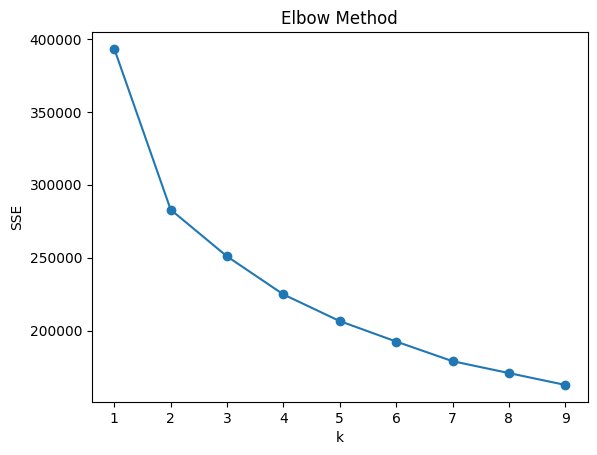

In [6]:
# Find Optimal K using the Elbow Method
sse = [] # List to store sum of squared errors for each k

# Try different values of k (number of clusters)
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    sse.append(km.inertia_) # inertia_ gives the SSE (sum of squared distances)

# Plotting k vs SSE to find the "elbow point"
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

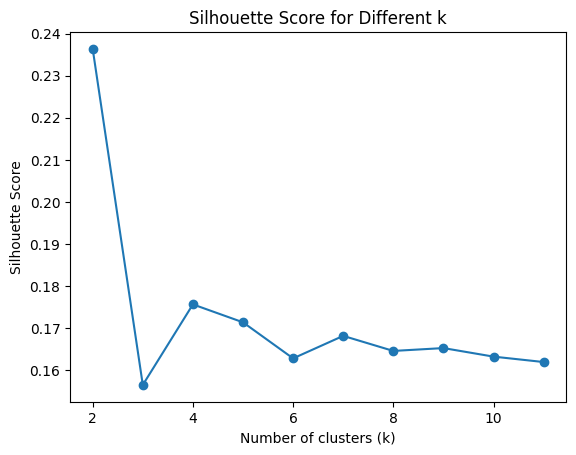

In [7]:
# Calculate Silhouette Scores for different k
sil_scores = []

for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)  # Calculate silhouette score for current k
    sil_scores.append(score)

# Plot Silhouette Scores to identify optimal k
plt.plot(range(2, 12), sil_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.show()

In [8]:
# Apply KMeans Clustering
# Choose k = 2
kmeans = KMeans(n_clusters=2, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(scaled_features)

### 🏷️ High-Value Customer Labeling

- Identify cluster with highest TotalSpend

- Label customers as HighValue = 1 or HighValue = 0

In [9]:
# Label High-Value Customers
# Assume the cluster with the highest TotalSpend is the high-value segment.
# Group by cluster and calculate mean TotalSpend and customer count
cluster_summary = customer_df.groupby('Cluster').agg({
    'TotalSpend': 'mean',
    'Customer ID': 'count'
}).rename(columns={'Customer ID': 'Count'})

print(cluster_summary)

# Identify the cluster with highest average spending
high_value_cluster = cluster_summary['TotalSpend'].idxmax()

# Mark customers in that cluster as HighValue = 1
customer_df['HighValue'] = customer_df['Cluster'].apply(lambda x: 1 if x == high_value_cluster else 0)

# Export customer_df to CSV
customer_df.to_csv('customer_segmentation.csv', index=False)

customer_df.head(20)

          TotalSpend  Count
Cluster                    
0        1964.494555  28559
1        4828.070919  20587


,Customer ID,TotalSpend,AvgSpend,NumPurchases,TotalQty,Recency,CustomerAge,Returns,Gender,Cluster,HighValue
0,44605,3336,667.200000,5,12,132,31,4.0,1,1,1
1,13738,2583,861.000000,3,12,216,27,2.0,1,0,0
2,33969,4210,701.666667,6,13,56,27,2.0,0,1,1
3,42650,3376,306.909091,11,29,136,20,7.0,1,1,1
4,24053,2737,547.400000,5,13,371,53,3.0,0,1,1
5,19676,3290,822.500000,4,13,440,57,3.0,0,0,0
6,16051,4264,533.000000,8,21,512,45,3.0,0,1,1
7,23734,1628,407.000000,4,11,356,18,2.0,0,0,0
8,16921,2558,426.333333,6,13,232,54,5.0,0,1,1
9,7796,2473,618.250000,4,11,326,21,2.0,0,0,0


### 🤖 Predicting High-Value Customers

- Prepare dataset (features and target)

- Train-Test Split with stratification

- Train a Random Forest Classifier

- Evaluate using classification report

In [10]:
# Step 1: Feature Selection
# Define input features (X) and target variable (y)
# 'HighValue' is the target (1 = High Value Customer, 0 = Not High Value)
X = customer_df[['Customer ID', 'TotalSpend', 'AvgSpend', 'NumPurchases', 'Recency', 'CustomerAge', 'Gender', 'Returns']]
y = customer_df['HighValue']

In [11]:
# Step 2: Train-Test Split
# Split the data into training and testing sets
# Stratify ensures the HighValue (1/0) distribution is similar in both train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [12]:
# Step 3: Model Training
# Initialize Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# Step 4: Prediction
# Predict on the test set
y_pred = clf.predict(X_test)

In [14]:
# Step 5: Evaluation
# Print the classification report: Precision, Recall, F1-Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5712
           1       0.97      0.96      0.96      4118

    accuracy                           0.97      9830
   macro avg       0.97      0.97      0.97      9830
weighted avg       0.97      0.97      0.97      9830



### 🆕 Demo: Predict High-Value for New Customers

- Create sample new customer data

- Predict whether a new customer is high-value or not

In [15]:
# Predict high-value for new input (New Customer)
new_customer = pd.DataFrame([{
    'Customer ID': 44605,
    'TotalSpend': 5336,
    'AvgSpend': 1067.2,
    'NumPurchases': 5,
    'Recency': 19,
    'CustomerAge': 35,
    'Gender': 0,
    'Returns': 1 
}])

print("High-Value Prediction:", clf.predict(new_customer)[0])

High-Value Prediction: 1


### 📊 Tableau Analysis

Link: https://public.tableau.com/app/profile/litesh.ghute/viz/CustomerSegmentationDashboard_17457682264960/CustomerSegmentationDashboard

### THE END :)